In [28]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim

# 等価回路の作成

In [29]:
df_nostress = pd.read_csv("data_IM_ns_real.csv")
df_nostress["V1"] = df_nostress["V"] / np.sqrt(3)
df_nostress["P1"] = df_nostress["P"] / 3

Y_0 = 3.68e-03-9.36e-02j
G_0 = 3.68e-03
B_0 = -9.36e-02


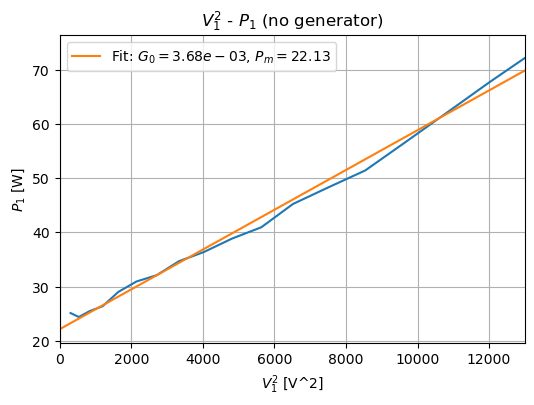

In [30]:

axessetting = AxesSetting(legend=True, xlabel="$V_1^2$ [V^2]", ylabel="$P_1$ [W]", grid="both", title="$V_1^2$ - $P_1$ (no generator)", xlim=(0, 13000))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(df_nostress["V1"]**2, df_nostress["P1"])


P_th = lambda Vsq, G0, Pm: G0 * Vsq + Pm

popt, pcov = curve_fit(P_th, df_nostress["V1"]**2, df_nostress["P1"])
Y_0 = df_nostress.iloc[-1]["I1"]/df_nostress.iloc[-1]["V1"]
G_0 = popt[0]
B_0 = -np.sqrt(Y_0**2 - G_0**2)
Y_0 = G_0 + 1j * B_0
axessetting.plot_func(ax, lambda x: P_th(x, *popt), label="Fit: $G_0 = {:.2e}$, $P_m = {:.2f}$".format(*popt))
axessetting.apply_axes(ax)

print(f"Y_0 = {Y_0:.2e}")
print(f"G_0 = {G_0:.2e}")
print(f"B_0 = {B_0:.2e}")

Y_0 = 3.76e-03-8.22e-02j
G_0 = 3.76e-03
B_0 = -8.22e-02


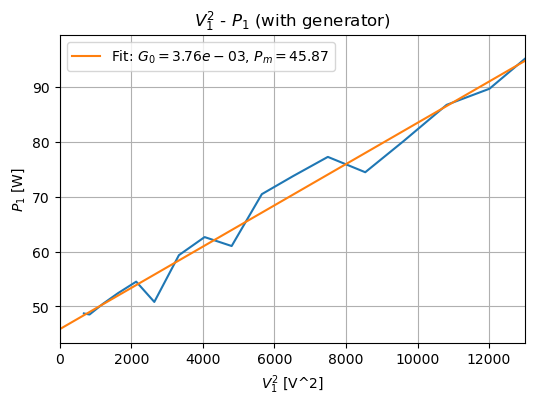

In [31]:
df_ns_gen = pd.read_csv("data_IM_ns_generator.csv")
df_ns_gen["V1"] = df_ns_gen["V"] / np.sqrt(3)
df_ns_gen["P1"] = df_ns_gen["P"] / 3

axessetting = AxesSetting(legend=True, xlabel="$V_1^2$ [V^2]", ylabel="$P_1$ [W]", grid="both", title="$V_1^2$ - $P_1$ (with generator)", xlim=(0, 13000))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(df_ns_gen["V1"]**2, df_ns_gen["P1"])


P_th = lambda Vsq, G0, Pm: G0 * Vsq + Pm

popt, pcov = curve_fit(P_th, df_ns_gen["V1"]**2, df_ns_gen["P1"])
Y_0 = df_ns_gen.iloc[-1]["I1"]/df_ns_gen.iloc[-1]["V1"]
G_0 = popt[0]
B_0 = -np.sqrt(Y_0**2 - G_0**2)
Y_0 = G_0 + 1j * B_0
axessetting.plot_func(ax, lambda x: P_th(x, *popt), label="Fit: $G_0 = {:.2e}$, $P_m = {:.2f}$".format(*popt))
axessetting.apply_axes(ax)

print(f"Y_0 = {Y_0:.2e}")
print(f"G_0 = {G_0:.2e}")
print(f"B_0 = {B_0:.2e}")

## 拘束試験

In [32]:
# 短絡の測定
I_short = 9.5
V_short = 41.6/np.sqrt(3)
P_short = 371/3
phase_short = 0

#
print(f"P (measured) = {P_short : .2f}")

R_1 = P_short/I_short**2
X_1 = np.sqrt((V_short/I_short)**2 - R_1**2)
Z_1 = R_1 + 1j * X_1

print(f"R_1 = {R_1 : .2f}")
print(f"X_1 = {X_1 : .2f}")
print(f"Z_1 = {Z_1 : .2f}")
print(f"|Z_1| = {np.abs(Z_1) : .2f}")

P (measured) =  123.67
R_1 =  1.37
X_1 =  2.12
Z_1 =  1.37+2.12j
|Z_1| =  2.53


# 速度試験

In [33]:
r1 = R_1 / 2 * (234.5 + 75) / (234.5 + 25)
print(r1)
r2 = R_1 / 2 * (234.5 + 75) / (234.5 + 25)
V_1 = 200/np.sqrt(3)
I_1 = lambda s: V_1/np.sqrt((r1+r2/s)**2 + X_1**2)
P_a = lambda s: 3 * I_1(s)**2 * r2 / s
P_out = lambda s: 3 * I_1(s)**2*r2*(1-s)/s
Sdot = lambda s: 3 * V_1**2 * np.conj(Y_0 + 1/(r1 + r2/s + 1j * X_1))
efficiency = lambda s: P_out(s) / np.real(Sdot(s)) * 100

pf = lambda s: np.real(Sdot(s)) / np.abs(Sdot(s))
torque = lambda s, p, f: 3*V_1**2*r2/(2*np.pi*f/p*((r1+r2/s)**2 + X_1**2) * s)


0.8171442702690201


In [34]:
df_speed = pd.read_csv("data_IM_stress_real.csv")
L = 0.287
g = 9.81

ns = 60*50/2
df_speed["s"]=(ns-df_speed["n"])/ns
df_speed["pf"] = df_speed["P1"]/df_speed["V1"]/df_speed["I1"]/np.sqrt(3)
df_speed["T"] = df_speed["W"]*g*L
df_speed["P_Z"] = df_speed["T"]*2*np.pi*df_speed["n"]/60
df_speed["eff_T"] = df_speed["P_Z"]/df_speed["P1"]*100
df_speed["eff_lamp"] = df_speed["V2"]*df_speed["I2"]/df_speed["P1"]*100


/tmp/ipykernel_14238/2070448353.py:5: RuntimeWarning: divide by zero encountered in divide
  I_1 = lambda s: V_1/np.sqrt((r1+r2/s)**2 + X_1**2)


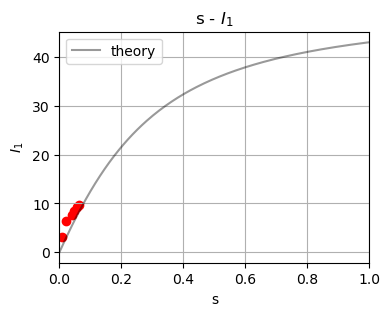

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
axessetting = AxesSetting(legend=True, xlabel="s", ylabel="$I_1$", grid="both", xlim=(0, 1), title="s - $I_1$")

axessetting.plot_func(ax, I_1, label="theory", c="black", alpha=0.4)
ax.scatter(df_speed["s"], df_speed["I1"], c="red")
axessetting.apply_axes(ax)

/tmp/ipykernel_14238/2070448353.py:5: RuntimeWarning: divide by zero encountered in divide
  I_1 = lambda s: V_1/np.sqrt((r1+r2/s)**2 + X_1**2)
/tmp/ipykernel_14238/2070448353.py:6: RuntimeWarning: invalid value encountered in divide
  P_a = lambda s: 3 * I_1(s)**2 * r2 / s


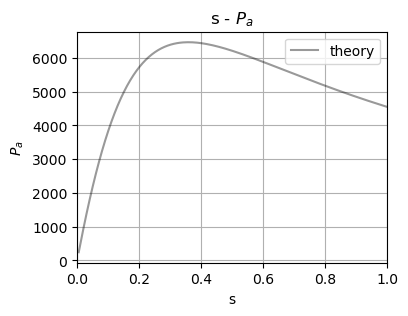

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
axessetting = AxesSetting(legend=True, xlabel="s", ylabel="$P_a$", grid="both", xlim=(0, 1), title="s - $P_a$")

axessetting.plot_func(ax, P_a, label="theory", c="black", alpha=0.4)
# ax.scatter(df_trans["I2"], df_trans["P2"]/df_trans["P1"]*100, c="red")
axessetting.apply_axes(ax)

/tmp/ipykernel_14238/2070448353.py:5: RuntimeWarning: divide by zero encountered in divide
  I_1 = lambda s: V_1/np.sqrt((r1+r2/s)**2 + X_1**2)
/tmp/ipykernel_14238/2070448353.py:7: RuntimeWarning: invalid value encountered in divide
  P_out = lambda s: 3 * I_1(s)**2*r2*(1-s)/s
/tmp/ipykernel_14238/2070448353.py:8: RuntimeWarning: divide by zero encountered in divide
  Sdot = lambda s: 3 * V_1**2 * np.conj(Y_0 + 1/(r1 + r2/s + 1j * X_1))


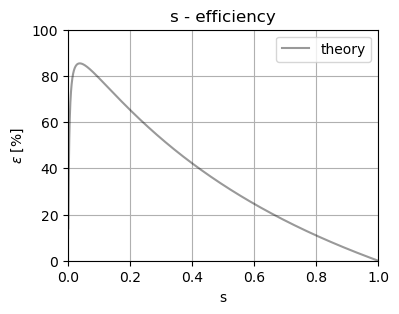

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
axessetting = AxesSetting(legend=True, xlabel="s", ylabel="$\epsilon$ [%]", grid="both", xlim=(0, 1), title="s - efficiency", ylim=(0, 100))
axessetting.plot_func(ax, efficiency, label="theory", c="black", alpha=0.4, samplesize=2000)
ax.scatter(df_speed["s"], df_speed["eff_T"], c="red", label="Efficiency (Torque)")
ax.scatter(df_speed["s"], df_speed["eff_lamp"], c="red", label="Efficiency (Lamp)")
axessetting.apply_axes(ax)

/tmp/ipykernel_14238/2070448353.py:8: RuntimeWarning: divide by zero encountered in divide
  Sdot = lambda s: 3 * V_1**2 * np.conj(Y_0 + 1/(r1 + r2/s + 1j * X_1))


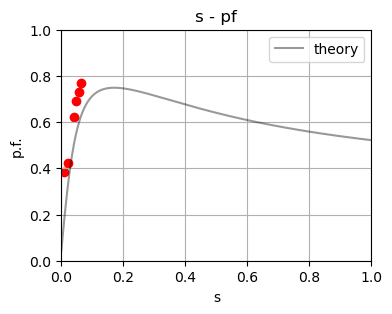

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
axessetting = AxesSetting(legend=True, xlabel="s", ylabel="p.f.", grid="both", xlim=(0, 1), title="s - pf", ylim=(0, 1))
axessetting.plot_func(ax, pf, label="theory", c="black", alpha=0.4, samplesize=2000)
ax.scatter(df_speed["s"], df_speed["pf"], c="red")
axessetting.apply_axes(ax)

/tmp/ipykernel_14238/2070448353.py:12: RuntimeWarning: divide by zero encountered in divide
  torque = lambda s, p, f: 3*V_1**2*r2/(2*np.pi*f/p*((r1+r2/s)**2 + X_1**2) * s)
/tmp/ipykernel_14238/2070448353.py:12: RuntimeWarning: invalid value encountered in multiply
  torque = lambda s, p, f: 3*V_1**2*r2/(2*np.pi*f/p*((r1+r2/s)**2 + X_1**2) * s)


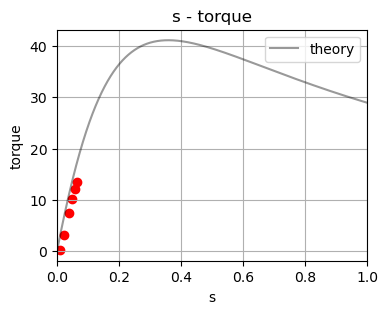

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
axessetting = AxesSetting(legend=True, xlabel="s", ylabel="torque", grid="both", xlim=(0, 1), title="s - torque")
axessetting.plot_func(ax, lambda s: torque(s, 2, 50), label="theory", c="black", alpha=0.4, samplesize=2000)
ax.scatter(df_speed["s"], df_speed["T"], c="red")
axessetting.apply_axes(ax)

/tmp/ipykernel_14238/2070448353.py:5: RuntimeWarning: divide by zero encountered in divide
  I_1 = lambda s: V_1/np.sqrt((r1+r2/s)**2 + X_1**2)
/tmp/ipykernel_14238/2070448353.py:7: RuntimeWarning: invalid value encountered in divide
  P_out = lambda s: 3 * I_1(s)**2*r2*(1-s)/s
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_14238/2070448353.py:8: RuntimeWarning: divide by zero encountered in divide
  Sdot = lambda s: 3 * V_1**2 * np.conj(Y_0 + 1/(r1 + r2/s + 1j * X_1))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start wit

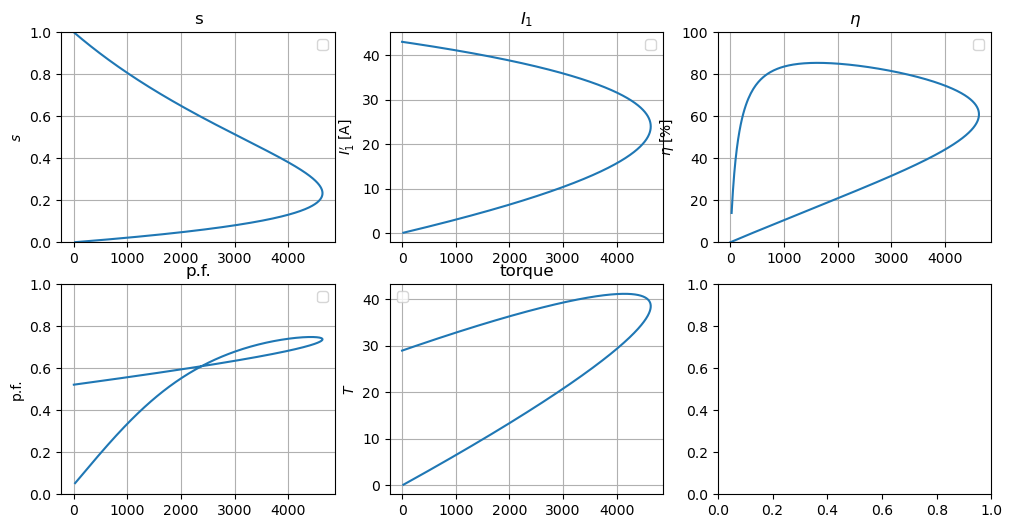

In [40]:
s = np.linspace(0, 1, 2000)
pout = P_out(s)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
# s
axs = AxesSetting(legend=True, ylabel="$s$", grid="both", ylim=(0, 1), title="s")
ax[0, 0].plot(pout, s)
axs.apply_axes(ax[0,0])
# I1'
ax[0,1].plot(pout, I_1(s))
axs = AxesSetting(legend=True, ylabel="$I_1'$ [A]", grid="both", title="$I_1$")
axs.apply_axes(ax[0,1])
# η
ax[0,2].plot(pout, efficiency(s))
axs = AxesSetting(legend=True, ylabel="$\eta$ [%]", grid="both", title="$\eta$", ylim=(0, 100))
axs.apply_axes(ax[0,2])
# p.f.
ax[1,0].plot(pout, pf(s))
axs = AxesSetting(legend=True, ylabel="p.f.", grid="both", title="p.f.", ylim=(0, 1))
axs.apply_axes(ax[1,0])
# torque
ax[1,1].plot(pout, torque(s, 2, 50))
axs = AxesSetting(legend=True, ylabel="$T$", grid="both", title="torque")
axs.apply_axes(ax[1,1])